Face Mask classification using CNN


---



---



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install --upgrade imutils

  Preparing metadata (setup.py) ... - done
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=2647f2a814cc11233ef4e257cdaf27fcd77be52e0675355795f5223b2a22a012
  Stored in directory: /root/.cache/pip/wheels/86/d7/0a/4923351ed1cec5d5e24c1eaf8905567b02a0343b24aa873df2
Successfully built imutils


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [ ]:
print("[INFO] loading images...")
imagePaths = list(paths.list_images("/content/drive/MyDrive/CVPR/FaceMask/dataset"))
data = []
labels = []

[INFO] loading images...


In [ ]:
# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the input image (224x224) and preprocess it
	image = load_img(imagePath, target_size=(224, 224))
	image = img_to_array(image)
	image = preprocess_input(image)

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

In [ ]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.20, stratify=labels, random_state=42)

# construct the training image generator for data augmentation
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit(
	aug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

2022-01-07 14:53:35.393379: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 14:53:35.511378: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 14:53:35.512520: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-07 14:53:35.514042: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

9420800/9406464 [==============================] - 0s 0us/step
[INFO] compiling model...
[INFO] training head...


/opt/conda/lib/python3.7/site-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
2022-01-07 14:53:40.271144: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-01-07 14:53:44.662304: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


34/34 [==============================] - 23s 382ms/step - loss: 0.5916 - accuracy: 0.7200 - val_loss: 0.2356 - val_accuracy: 0.9928
Epoch 2/20
34/34 [==============================] - 11s 332ms/step - loss: 0.2389 - accuracy: 0.9597 - val_loss: 0.1060 - val_accuracy: 1.0000
Epoch 3/20
34/34 [==============================] - 12s 351ms/step - loss: 0.1340 - accuracy: 0.9794 - val_loss: 0.0622 - val_accuracy: 1.0000
Epoch 4/20
34/34 [==============================] - 11s 335ms/step - loss: 0.1028 - accuracy: 0.9813 - val_loss: 0.0418 - val_accuracy: 1.0000
Epoch 5/20
34/34 [==============================] - 12s 355ms/step - loss: 0.0820 - accuracy: 0.9841 - val_loss: 0.0327 - val_accuracy: 1.0000
Epoch 6/20
34/34 [==============================] - 11s 331ms/step - loss: 0.0608 - accuracy: 0.9897 - val_loss: 0.0254 - val_accuracy: 1.0000
Epoch 7/20
34/34 [==============================] - 11s 343ms/step - loss: 0.0455 - accuracy: 0.9916 - val_loss: 0.0202 - val_accuracy: 1.0000
Epoch 8/20

[INFO] saving mask detector model...


/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


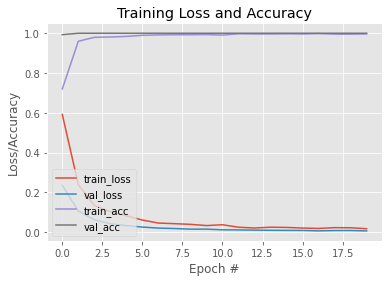

In [ ]:
# serialize the model to disk
print("[INFO] saving mask detector model...")
model.save("./FaceMaskDetectionModel", save_format="h5")

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
#plt.savefig(args["plot"])

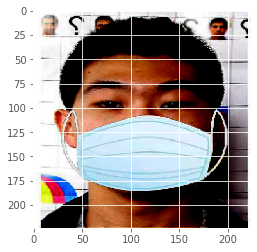

Predicted: 
1
True:
1


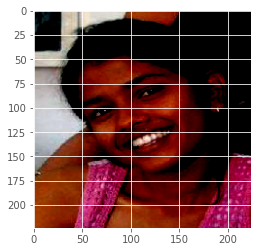

Predicted: 
0
True:
0


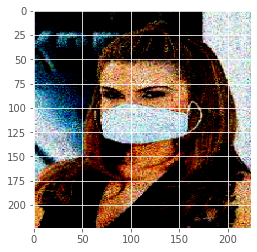

Predicted: 
1
True:
1


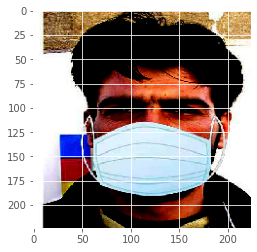

Predicted: 
1
True:
1


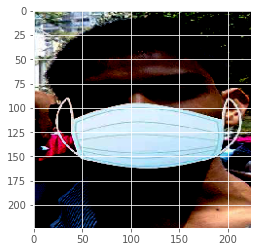

Predicted: 
1
True:
1


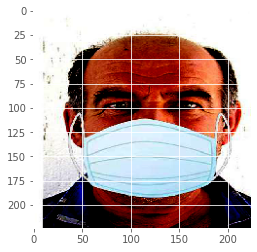

Predicted: 
1
True:
1


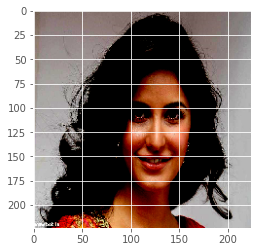

Predicted: 
0
True:
0


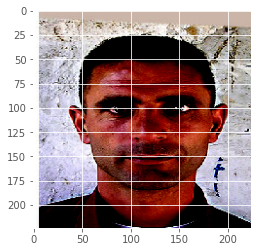

Predicted: 
0
True:
0


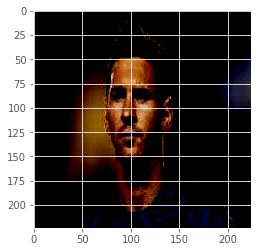

Predicted: 
0
True:
0


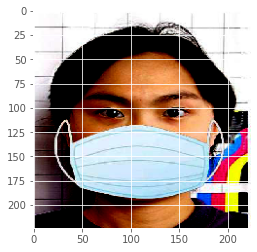

Predicted: 
1
True:
1


In [ ]:
Predictions=model.predict(testX[10:20])
for i in range(10,20):
    X_1=testX[i]
    Y_1=testY[i]
    plt.imshow(X_1)
    plt.show()
    print("Predicted: ")
    print(np.argmax(Predictions[i-10]))
    print("True:")
    print(np.argmax(testY[i]))
    